## Feature Selection

### Imports

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

%matplotlib inline

### Pré-processamento

#### Baixa sos dados

In [2]:
!curl --remote-name \
     -H 'Accept: application/vnd.github.v3.raw' \
     --location https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 60302  100 60302    0     0  60788      0 --:--:-- --:--:-- --:--:-- 60727


#### Carrega os dados

In [3]:
titanic = pd.read_csv('titanic.csv')

titanic.columns = ['IdPassageiro',
                   'Sobreviveu?', 
                   'Classe',
                   'Nome',
                   'Sexo',
                   'Idade',
                   'Irmãos/Cônjuge',
                   'Pais/Crianças',
                   'Bilhete',
                   'Tarifa',
                   'Cabine',
                   'Embarque']

titanic = titanic.set_index('IdPassageiro')
titanic.drop(['Nome','Bilhete','Cabine'], axis=1, inplace = True)
titanic.head()

,Sobreviveu?,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque
IdPassageiro,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S
2,1,1,female,38.0,1,0,71.2833,C
3,1,3,female,26.0,0,0,7.9250,S
4,1,1,female,35.0,1,0,53.1000,S
5,0,3,male,35.0,0,0,8.0500,S


#### Missing Values

In [4]:
titanic.isna().sum()

Sobreviveu?         0
Classe              0
Sexo                0
Idade             177
Irmãos/Cônjuge      0
Pais/Crianças       0
Tarifa              0
Embarque            2
dtype: int64

In [5]:
titanic['Idade'].fillna(titanic['Idade'].mean(), inplace=True)
titanic['Embarque'].fillna(titanic['Embarque'].mode()[0], inplace=True)
titanic.isna().sum()

Sobreviveu?       0
Classe            0
Sexo              0
Idade             0
Irmãos/Cônjuge    0
Pais/Crianças     0
Tarifa            0
Embarque          0
dtype: int64

In [6]:
titanic.describe()

,Sobreviveu?,Classe,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,13.002015,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,29.699118,0.000000,0.000000,14.454200
75%,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


### Discretização de Dados Numéricos

#### Correlação entre Idade e Sobreviventes

In [7]:
titanic['Idade'].corr(titanic['Sobreviveu?'])

-0.06980851528714314

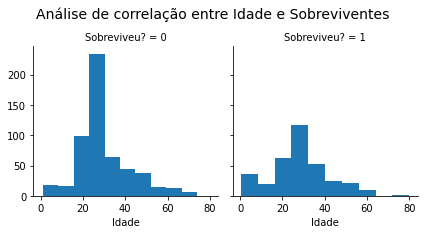

In [8]:
g = sns.FacetGrid(titanic, col='Sobreviveu?')
g.map(plt.hist, 'Idade', bins=10)
plt.suptitle('Análise de correlação entre Idade e Sobreviventes', y=1.07, size=14)
plt.show()

In [9]:
titanic['IdadeDisc'] = pd.cut(titanic['Idade'], 
                              bins=[0, 15, 25, 60, 80], 
                              labels=['Criança', 'Jovem', 'Adulto', 'Idoso'])

titanic.tail()

,Sobreviveu?,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,IdadeDisc
IdPassageiro,,,,,,,,,
887,0,2,male,27.000000,0,0,13.00,S,Adulto
888,1,1,female,19.000000,0,0,30.00,S,Jovem
889,0,3,female,29.699118,1,2,23.45,S,Adulto
890,1,1,male,26.000000,0,0,30.00,C,Adulto
891,0,3,male,32.000000,0,0,7.75,Q,Adulto


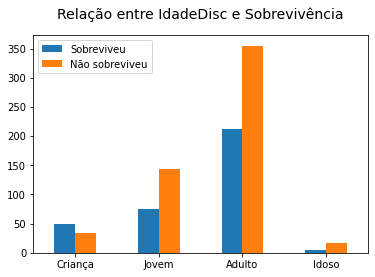

In [10]:
survived = titanic[titanic['Sobreviveu?'] == 1].groupby('IdadeDisc')['Sobreviveu?'].count().values
not_survived = titanic[titanic['Sobreviveu?'] == 0].groupby('IdadeDisc')['Sobreviveu?'].count().values
index = titanic[titanic['Sobreviveu?'] == 1].groupby('IdadeDisc')['Sobreviveu?'].count().index.values

df = pd.DataFrame({'Sobreviveu': survived, 'Não sobreviveu': not_survived}, index=index)

ax = df.plot.bar(rot=0)
plt.title('Relação entre IdadeDisc e Sobrevivência', y=1.05, size=14)
plt.show()

#### Correlação entre Tarifa e Sobrevivência

In [11]:
titanic['Tarifa'].corr(titanic['Sobreviveu?'])

0.2573065223849625

#### Intervalos para deixar a distribuição + equilibrada

In [12]:
intervals = pd.qcut(titanic['Tarifa'], 3).astype(str).unique()
intervals

array(['(-0.001, 8.662]', '(26.0, 512.329]', '(8.662, 26.0]'],
      dtype=object)

In [13]:
titanic['Tipo_tarifa'] = pd.qcut(titanic['Tarifa'], 3).astype(str).map({intervals[0]: 'Barato', 
                                                                        intervals[1]: 'Medio', 
                                                                        intervals[2]: 'Caro'}).astype(str)
titanic.head()

,Sobreviveu?,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,IdadeDisc,Tipo_tarifa
IdPassageiro,,,,,,,,,,
1,0,3,male,22.0,1,0,7.2500,S,Jovem,Barato
2,1,1,female,38.0,1,0,71.2833,C,Adulto,Medio
3,1,3,female,26.0,0,0,7.9250,S,Adulto,Barato
4,1,1,female,35.0,1,0,53.1000,S,Adulto,Medio
5,0,3,male,35.0,0,0,8.0500,S,Adulto,Barato


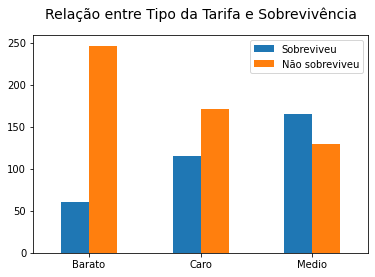

In [14]:
survived = titanic[titanic['Sobreviveu?'] == 1].groupby('Tipo_tarifa')['Sobreviveu?'].count().values
not_survived = titanic[titanic['Sobreviveu?'] == 0].groupby('Tipo_tarifa')['Sobreviveu?'].count().values
index = titanic[titanic['Sobreviveu?'] == 1].groupby('Tipo_tarifa')['Sobreviveu?'].count().index.values

df = pd.DataFrame({'Sobreviveu': survived, 'Não sobreviveu': not_survived}, index=index)

ax = df.plot.bar(rot=0)
plt.title('Relação entre Tipo da Tarifa e Sobrevivência', y=1.05, size=14)
plt.show()

### Transformação de Dados Categóricos

#### Mapeamento

In [15]:
titanic['Sexo'] = titanic['Sexo'].map({'female': 0, 'male': 1}).astype(int)
titanic['Embarque'] = titanic['Embarque'].map({'S': 0, 'C': 1, 'Q':2}).astype(int)
titanic.head()

,Sobreviveu?,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,IdadeDisc,Tipo_tarifa
IdPassageiro,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0,Jovem,Barato
2,1,1,0,38.0,1,0,71.2833,1,Adulto,Medio
3,1,3,0,26.0,0,0,7.9250,0,Adulto,Barato
4,1,1,0,35.0,1,0,53.1000,0,Adulto,Medio
5,0,3,1,35.0,0,0,8.0500,0,Adulto,Barato


#### One-hot Encoding

In [16]:
dummy = pd.get_dummies(titanic['IdadeDisc'])
titanic= pd.concat([titanic, dummy], axis=1)

dummy = pd.get_dummies(titanic['Tipo_tarifa'])
titanic = pd.concat([titanic, dummy], axis=1)

titanic.drop(['IdadeDisc', 'Tipo_tarifa'], axis=1, inplace=True)
titanic.head()

,Sobreviveu?,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,Criança,Jovem,Adulto,Idoso,Barato,Caro,Medio
IdPassageiro,,,,,,,,,,,,,,,
1,0,3,1,22.0,1,0,7.2500,0,0,1,0,0,1,0,0
2,1,1,0,38.0,1,0,71.2833,1,0,0,1,0,0,0,1
3,1,3,0,26.0,0,0,7.9250,0,0,0,1,0,1,0,0
4,1,1,0,35.0,1,0,53.1000,0,0,0,1,0,0,0,1
5,0,3,1,35.0,0,0,8.0500,0,0,0,1,0,1,0,0


### Normalização Min-Max  [0,1]

#### Salva a coluna alvo em nova variável

In [17]:
target = titanic['Sobreviveu?']
titanic.drop(['Sobreviveu?'], axis=1, inplace=True)

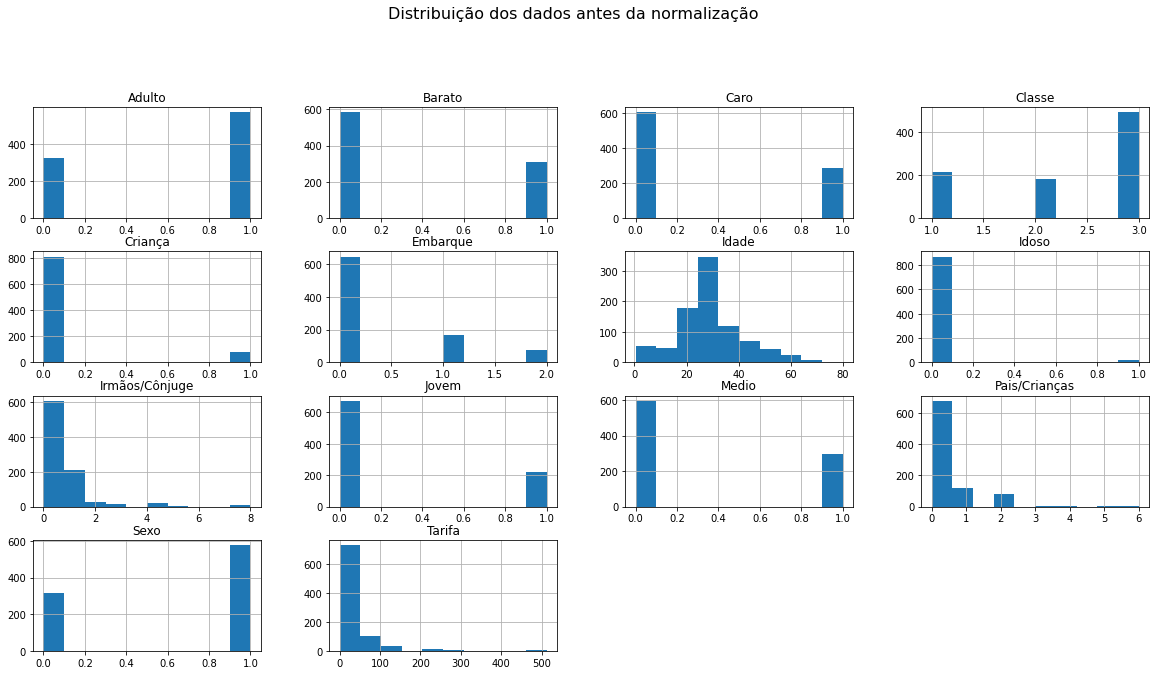

In [18]:
titanic.hist(figsize=(20, 10))
plt.suptitle('Distribuição dos dados antes da normalização', y=1.02, size=16)
plt.show()

#### MinMaxScaler() 

In [19]:
from sklearn import preprocessing

In [20]:
X = titanic.values
min_max_scaler = preprocessing.MinMaxScaler()

df_minmax = min_max_scaler.fit_transform(X)
df_minmax = pd.DataFrame(df_minmax, columns=titanic.columns)
df_minmax.head(2)

,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,Criança,Jovem,Adulto,Idoso,Barato,Caro,Medio
0,1.0,1.0,0.271174,0.125,0.0,0.014151,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.472229,0.125,0.0,0.139136,0.5,0.0,0.0,1.0,0.0,0.0,0.0,1.0


In [21]:
df_minmax.describe().round(2)

,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,Criança,Jovem,Adulto,Idoso,Barato,Caro,Medio
count,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00
mean,0.65,0.65,0.37,0.07,0.06,0.06,0.18,0.09,0.24,0.64,0.02,0.35,0.32,0.33
std,0.42,0.48,0.16,0.14,0.13,0.10,0.32,0.29,0.43,0.48,0.16,0.48,0.47,0.47
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.50,0.00,0.27,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,1.00,0.37,0.00,0.00,0.03,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00
75%,1.00,1.00,0.43,0.12,0.00,0.06,0.50,0.00,0.00,1.00,0.00,1.00,1.00,1.00
max,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


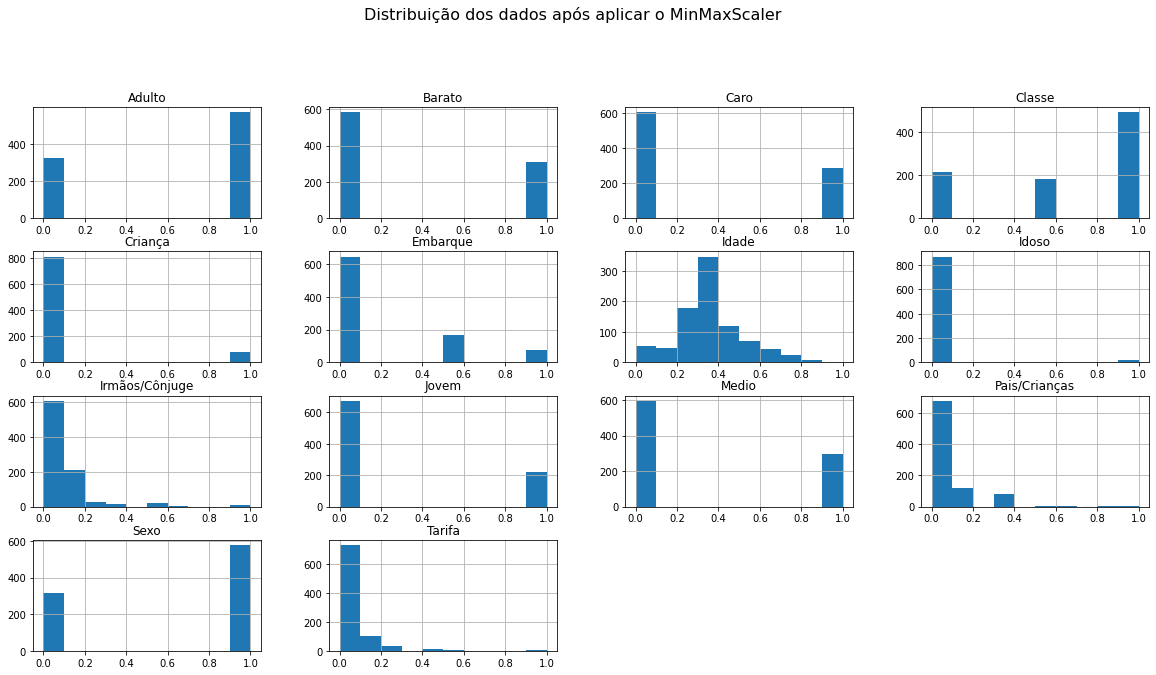

In [22]:
df_minmax.hist(figsize=[20, 10])
plt.suptitle('Distribuição dos dados após aplicar o MinMaxScaler', y=1.02, size=16)
plt.show()

### Normalização Gaussiana (Z-Score)

In [23]:
X = titanic.values
standard_scaler = preprocessing.StandardScaler()

df_standard = standard_scaler.fit_transform(X)
df_standard = pd.DataFrame(df_standard, columns=titanic.columns)
df_standard.head(2)

,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,Criança,Jovem,Adulto,Idoso,Barato,Caro,Medio
0,0.827377,0.737695,-0.592481,0.432793,-0.473674,-0.502445,-0.568837,-0.320504,1.757030,-1.326090,-0.159111,1.375811,-0.691095,-0.703539
1,-1.566107,-1.355574,0.638789,0.432793,-0.473674,0.786845,1.005181,-0.320504,-0.569142,0.754097,-0.159111,-0.726844,-0.691095,1.421386


In [24]:
df_standard.describe().round(2)

,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,Criança,Jovem,Adulto,Idoso,Barato,Caro,Medio
count,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00,891.00
mean,-0.00,-0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00,-0.00,0.00
std,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00
min,-1.57,-1.36,-2.25,-0.47,-0.47,-0.65,-0.57,-0.32,-0.57,-1.33,-0.16,-0.73,-0.69,-0.70
25%,-0.37,-1.36,-0.59,-0.47,-0.47,-0.49,-0.57,-0.32,-0.57,-1.33,-0.16,-0.73,-0.69,-0.70
50%,0.83,0.74,0.00,-0.47,-0.47,-0.36,-0.57,-0.32,-0.57,0.75,-0.16,-0.73,-0.69,-0.70
75%,0.83,0.74,0.41,0.43,-0.47,-0.02,1.01,-0.32,-0.57,0.75,-0.16,1.38,1.45,1.42
max,0.83,0.74,3.87,6.78,6.97,9.67,2.58,3.12,1.76,0.75,6.28,1.38,1.45,1.42


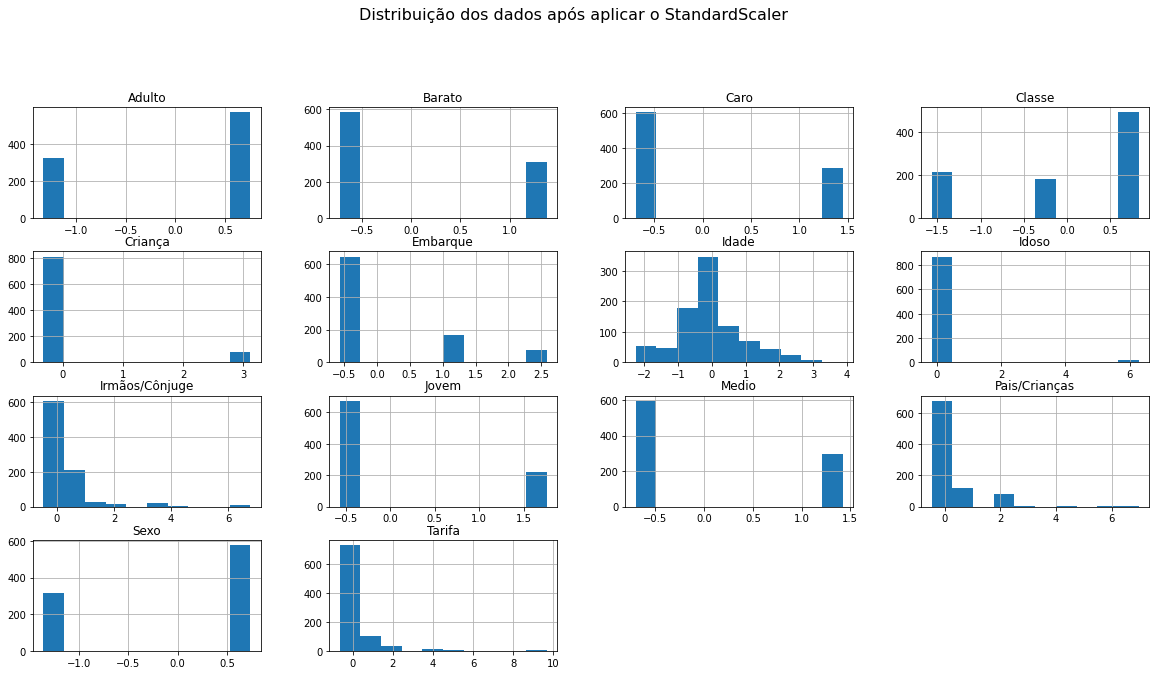

In [25]:
df_standard.hist(figsize=(20,10))
plt.suptitle('Distribuição dos dados após aplicar o StandardScaler', y=1.02, size=16)
plt.show()

### Redução de Dimensionalidade

#### PCA

In [26]:
from sklearn.decomposition import PCA

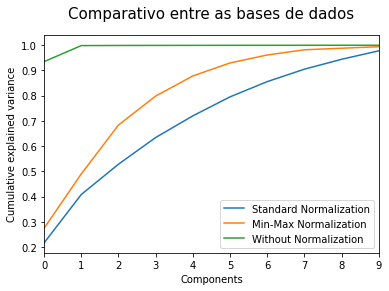

In [27]:
X = df_standard.values
pca = PCA(n_components=10)
pca.fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='Standard Normalization')

X = df_minmax.values
pca = PCA(n_components=10)
pca.fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='Min-Max Normalization')

X = titanic.values
pca = PCA(n_components=10)
pca.fit(X)
plt.plot(np.cumsum(pca.explained_variance_ratio_), label='Without Normalization')

plt.xlim(0,9,1)
plt.title('Comparativo entre as bases de dados', y=1.05, size=15)
plt.xlabel('Components')
plt.ylabel('Cumulative explained variance')
plt.legend()
plt.show()

#### Variância de cada coluna do dataframe

In [28]:
titanic.var().sort_values(ascending=False)

Tarifa            2469.436846
Idade              169.052400
Irmãos/Cônjuge       1.216043
Classe               0.699015
Pais/Crianças        0.649728
Embarque             0.404081
Adulto               0.231357
Sexo                 0.228475
Barato               0.226439
Medio                0.221718
Caro                 0.218999
Jovem                0.185014
Criança              0.084571
Idoso                0.024109
dtype: float64

#### Scatter plot dos DataFrames normalizados, após redução de dimensionalidade com PCA

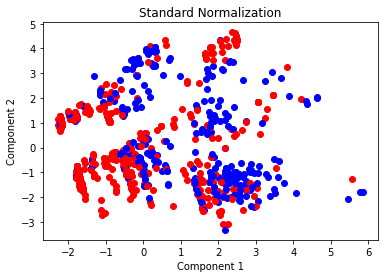

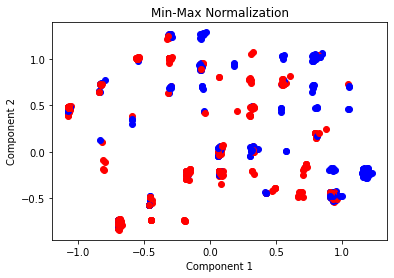

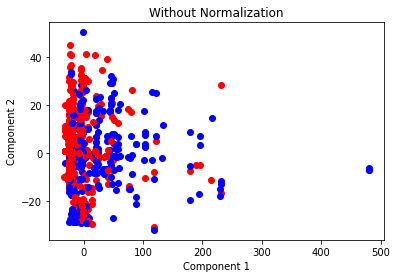

In [29]:
def plot_scatter(pca_data, target, title=''):
    colors = ['red', 'blue']
    
    for x, y in zip(pca_data, target):
        plt.scatter(x[0], x[1], label=y, color=colors[y])
    
    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    return plt.show()


X = df_standard.values
pca = PCA(n_components=2)
data = pca.fit_transform(X)
plot_scatter(data, target, title='Standard Normalization')

X = df_minmax.values
pca = PCA(n_components=2)
data = pca.fit_transform(X)
plot_scatter(data, target, title='Min-Max Normalization')

X = titanic.values
pca = PCA(n_components=2)
data = pca.fit_transform(X)
plot_scatter(data, target, title='Without Normalization')

#### SVD (Singular value decomposition)

In [30]:
from sklearn.decomposition import TruncatedSVD

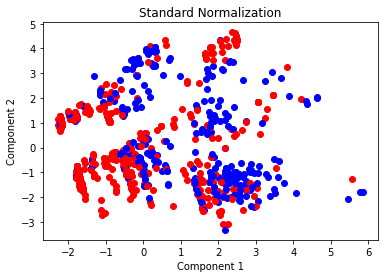

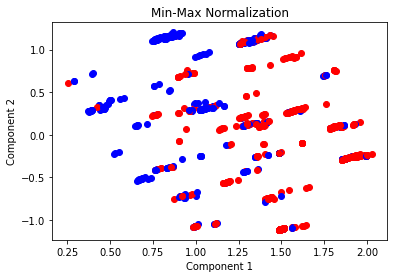

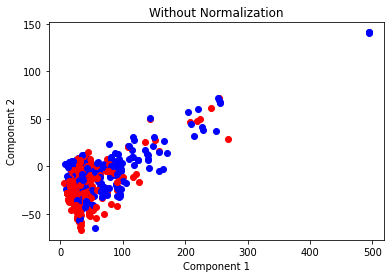

In [31]:
X = df_standard.values
svd = TruncatedSVD(n_components=2, n_iter=5)
data = svd.fit_transform(X)
plot_scatter(data, target, title='Standard Normalization')

X = df_minmax.values
svd = TruncatedSVD(n_components=2, n_iter=5)
data = svd.fit_transform(X)
plot_scatter(data, target, title='Min-Max Normalization')

X = titanic.values
svd = TruncatedSVD(n_components=2, n_iter=5)
data = svd.fit_transform(X)
plot_scatter(data, target, title='Without Normalization')

#### t-SNE (t-distributed Stochastic Neighbor Embedding)

In [32]:
from sklearn.manifold import TSNE

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 891 samples in 0.003s...
[t-SNE] Computed neighbors for 891 samples in 0.019s...
[t-SNE] Computed conditional probabilities for sample 891 / 891
[t-SNE] Mean sigma: 0.000000
[t-SNE] KL divergence after 250 iterations with early exaggeration: 61.959030
[t-SNE] KL divergence after 300 iterations: 0.962503


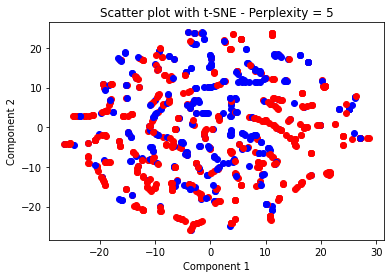

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 891 samples in 0.001s...
[t-SNE] Computed neighbors for 891 samples in 0.018s...
[t-SNE] Computed conditional probabilities for sample 891 / 891
[t-SNE] Mean sigma: 1.165312
[t-SNE] KL divergence after 250 iterations with early exaggeration: 53.159081
[t-SNE] KL divergence after 300 iterations: 0.377374


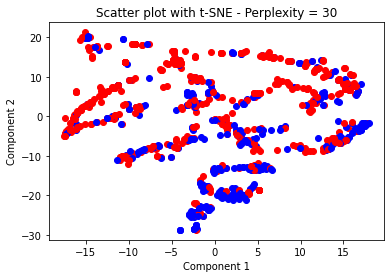

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 891 samples in 0.001s...
[t-SNE] Computed neighbors for 891 samples in 0.026s...
[t-SNE] Computed conditional probabilities for sample 891 / 891
[t-SNE] Mean sigma: 1.912064
[t-SNE] KL divergence after 250 iterations with early exaggeration: 51.774673
[t-SNE] KL divergence after 300 iterations: 0.298846


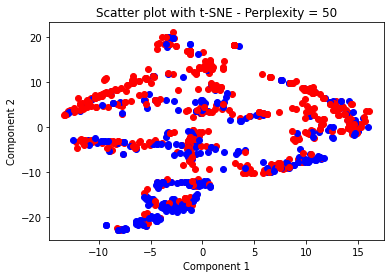

In [33]:
X = titanic.values

tsne = TSNE(n_components=2, verbose=1, perplexity=5, n_iter=300)
data = tsne.fit_transform(X)
plot_scatter(data, target, title='Scatter plot with t-SNE - Perplexity = 5')

tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=300)
data = tsne.fit_transform(X)
plot_scatter(data, target, title='Scatter plot with t-SNE - Perplexity = 30')

tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300)
data = tsne.fit_transform(X)
plot_scatter(data, target, title='Scatter plot with t-SNE - Perplexity = 50')

####  Isomap

In [34]:
from sklearn.manifold import Isomap

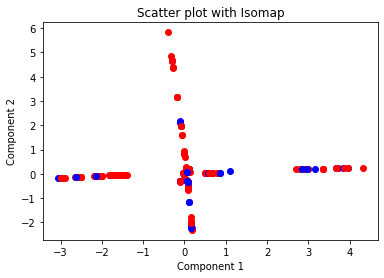

In [35]:
X = df_minmax.values
isomap = Isomap(n_components=2)
data = isomap.fit_transform(X)
plot_scatter(data, target, title='Scatter plot with Isomap')

### Feature Selection

####  Information Gain (Decision Tree)

In [36]:
from sklearn.tree import DecisionTreeClassifier

[0.08206444 0.23801931 0.25705955 0.03200845 0.02832785 0.28919898
 0.03423199 0.01224189 0.00570112 0.01428974 0.         0.
 0.00440205 0.00245463]


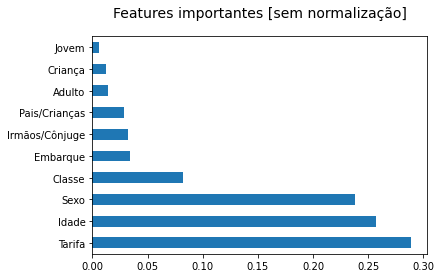

In [37]:
dtree = DecisionTreeClassifier(criterion='entropy')
dtree.fit(titanic, target)
print(dtree.feature_importances_)

feat_importances = pd.Series(dtree.feature_importances_, index=titanic.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Features importantes [sem normalização]', y=1.06, size=14)
plt.show()

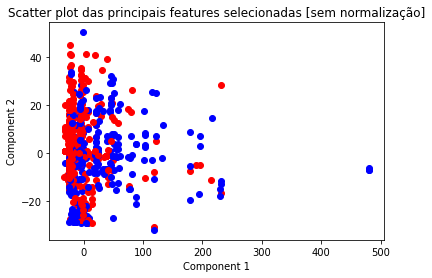

In [38]:
X = titanic[['Tarifa', 'Idade', 'Sexo', 'Classe']].values
pca = PCA(n_components=2)
data = pca.fit_transform(X)
plot_scatter(data, target, title='Scatter plot das principais features selecionadas [sem normalização]')
plt.show()

[0.08873243 0.23801931 0.27503812 0.02786418 0.02952411 0.29444321
 0.02385263 0.01224189 0.         0.00567622 0.00113232 0.00194742
 0.         0.00152814]


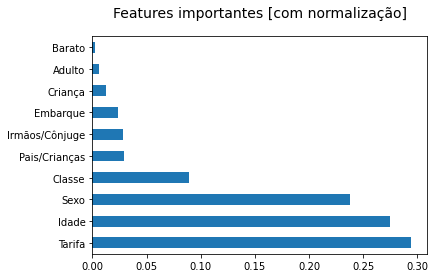

In [39]:
dtree = DecisionTreeClassifier(criterion='entropy')
dtree.fit(df_minmax,target)
print(dtree.feature_importances_)

feat_importances = pd.Series(dtree.feature_importances_, index=titanic.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Features importantes [com normalização]', y=1.06, size=14)
plt.show()

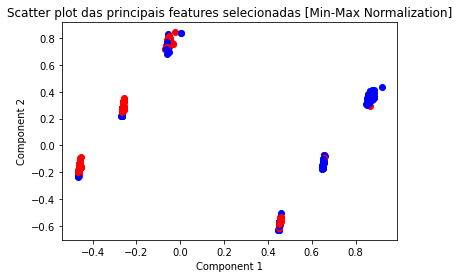

In [40]:
X = df_minmax[['Tarifa', 'Idade', 'Sexo', 'Classe']].values
pca = PCA(n_components=2)
data = pca.fit_transform(X)
plot_scatter(data, target, title='Scatter plot das principais features selecionadas [Min-Max Normalization]')
plt.show()

#### Gini (Random Forest)

In [41]:
from sklearn.ensemble import RandomForestClassifier

[0.07413405 0.25417089 0.21685879 0.05363175 0.04002614 0.22903435
 0.03513125 0.02087572 0.01006724 0.0125848  0.00445464 0.01712944
 0.01028475 0.02161618]


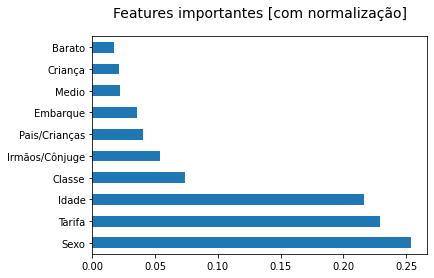

In [42]:
clf = RandomForestClassifier(criterion='gini')
clf.fit(df_minmax, target)
print(clf.feature_importances_)
feat_importances = pd.Series(clf.feature_importances_, index=titanic.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.title('Features importantes [com normalização]', y=1.06, size=14)
plt.show()

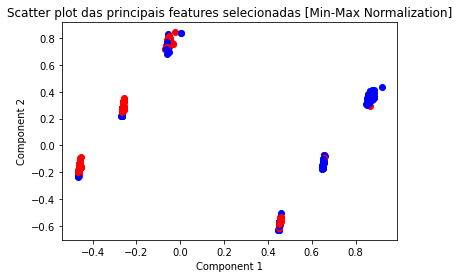

In [43]:
X = df_minmax[['Tarifa', 'Idade', 'Sexo', 'Classe']].values
pca = PCA(n_components=2)
data = pca.fit_transform(X)
plot_scatter(data, target, title='Scatter plot das principais features selecionadas [Min-Max Normalization]')
plt.show()

### Amostragem

#### Amostra não estratificada

In [44]:
amostra = titanic.sample(frac=.25)
amostra.head()

,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,Criança,Jovem,Adulto,Idoso,Barato,Caro,Medio
IdPassageiro,,,,,,,,,,,,,,
531,2,0,2.0,1,1,26.0000,0,1,0,0,0,0,1,0
311,1,0,24.0,0,0,83.1583,1,0,1,0,0,0,0,1
734,2,1,23.0,0,0,13.0000,0,0,1,0,0,0,1,0
677,3,1,24.5,0,0,8.0500,0,0,1,0,0,1,0,0
153,3,1,55.5,0,0,8.0500,0,0,0,1,0,1,0,0


#### Amostra estratificada

In [45]:
amostra_estratificada = titanic.groupby('Sexo').apply(lambda x : x.sample(frac=0.25))
amostra_estratificada.head()

Classe  Sexo  Idade  Irmãos/Cônjuge  Pais/Crianças  \
Sexo IdPassageiro                                                       
0    124                2     0   32.5               0              0   
     449                3     0    5.0               2              1   
     821                1     0   52.0               1              1   
     474                2     0   23.0               0              0   
     248                2     0   24.0               0              2   

                    Tarifa  Embarque  Criança  Jovem  Adulto  Idoso  Barato  \
Sexo IdPassageiro                                                             
0    124           13.0000         0        0      0       1      0       0   
     449           19.2583         1        1      0       0      0       0   
     821           93.5000         0        0      0       1      0       0   
     474           13.7917         1        0      1       0      0       0   
     248           14.5000         0        0      1       0      0       0   

                   Caro  Medio  
Sexo IdPassageiro               
0    124              1      0  
     449              1      0  
     821              0      1  
     474              1      0  
     248              1      0

#### Amostragem com agrupamento

In [48]:
from sklearn.cluster import KMeans

In [49]:
kmeans = KMeans(n_clusters=2).fit(df_standard)
centroides = kmeans.cluster_centers_
print(centroides)

[[-9.85991271e-01 -1.91858074e-01  1.85571542e-01  4.45096261e-01
   4.68875480e-01  8.35521555e-01  2.07797117e-03  1.69342839e-01
  -1.66990240e-01  6.63994552e-03  1.24862042e-01 -7.26843784e-01
  -6.91094740e-01  1.42138629e+00]
 [ 4.88032592e-01  9.49633086e-02 -9.18516862e-02 -2.20307713e-01
  -2.32077628e-01 -4.13555132e-01 -1.02852600e-03 -8.38190225e-02
   8.26545652e-02 -3.28655021e-03 -6.18025206e-02  3.59763283e-01
   3.42068705e-01 -7.03538516e-01]]


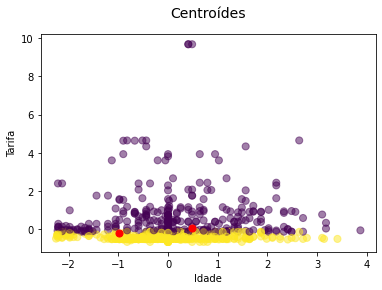

In [53]:
plt.scatter(df_standard['Idade'], df_standard['Tarifa'], c= kmeans.labels_.astype(float), s=50, alpha=0.5)
plt.scatter(centroides[:, 0], centroides[:, 1], c='red', s=50)
plt.title('Centroídes', y=1.05, size=14)
plt.xlabel('Idade')
plt.ylabel('Tarifa')
plt.show()

#### Amostra por agrupamento

In [52]:
df_standard['Agrupamento'] = kmeans.labels_
df_standard.head()

,Classe,Sexo,Idade,Irmãos/Cônjuge,Pais/Crianças,Tarifa,Embarque,Criança,Jovem,Adulto,Idoso,Barato,Caro,Medio,Agrupamento
0,0.827377,0.737695,-0.592481,0.432793,-0.473674,-0.502445,-0.568837,-0.320504,1.757030,-1.326090,-0.159111,1.375811,-0.691095,-0.703539,1
1,-1.566107,-1.355574,0.638789,0.432793,-0.473674,0.786845,1.005181,-0.320504,-0.569142,0.754097,-0.159111,-0.726844,-0.691095,1.421386,0
2,0.827377,-1.355574,-0.284663,-0.474545,-0.473674,-0.488854,-0.568837,-0.320504,-0.569142,0.754097,-0.159111,1.375811,-0.691095,-0.703539,1
3,-1.566107,-1.355574,0.407926,0.432793,-0.473674,0.420730,-0.568837,-0.320504,-0.569142,0.754097,-0.159111,-0.726844,-0.691095,1.421386,0
4,0.827377,0.737695,0.407926,-0.474545,-0.473674,-0.486337,-0.568837,-0.320504,-0.569142,0.754097,-0.159111,1.375811,-0.691095,-0.703539,1


#### Amostra estratificada por agrupamento

In [54]:
amostra_estratificada = df_standard.groupby('Agrupamento').apply(lambda x: x.sample(frac=0.25))
amostra_estratificada.head()

Classe      Sexo     Idade  Irmãos/Cônjuge  Pais/Crianças  \
Agrupamento                                                                    
0           698 -1.566107  0.737695  1.485287        0.432793       0.767630   
            273 -1.566107  0.737695  0.561835       -0.474545       0.767630   
            730 -1.566107 -1.355574 -0.053800       -0.474545      -0.473674   
            373 -1.566107  0.737695 -0.592481       -0.474545      -0.473674   
            692  0.827377  0.737695  0.000000       -0.474545      -0.473674   

                   Tarifa  Embarque   Criança     Jovem    Adulto     Idoso  \
Agrupamento                                                                   
0           698  1.584179  1.005181 -0.320504 -0.569142  0.754097 -0.159111   
            273 -0.050421  1.005181 -0.320504 -0.569142  0.754097 -0.159111   
            730  3.606793 -0.568837 -0.320504 -0.569142  0.754097 -0.159111   
            373  2.082512  1.005181 -0.320504  1.757030 -1.326090 -0.159111   
            692  0.489104 -0.568837 -0.320504 -0.569142  0.754097 -0.159111   

                   Barato      Caro     Medio  Agrupamento  
Agrupamento                                                 
0           698 -0.726844 -0.691095  1.421386            0  
            273 -0.726844 -0.691095  1.421386            0  
            730 -0.726844 -0.691095  1.421386            0  
            373 -0.726844 -0.691095  1.421386            0  
            692 -0.726844 -0.691095  1.421386            0